In [1]:
import numpy as np
import matplotlib.pyplot as plt

Moteur de pricing multilevel monte carlo

In [9]:
from abc import ABC, abstractmethod

from numpy import ndarray

class model(ABC) : 
   @abstractmethod
   def __init__(self,interest_rate : float, initial_value: ndarray) -> None:
      self.dimension = initial_value.shape[0]
      # print("dimension : "+str(self.dimension))
      self.initial_value =initial_value
      self.interest_rate = interest_rate

   @abstractmethod
   def drift(self, t : float, x : ndarray)->ndarray:
      pass
   @abstractmethod
   def diffusion(self, t:float,x:ndarray)->ndarray:
      pass
   
class black_sholes(model):
  def __init__(self,initial_value: ndarray,interest_rate : float, sigma: float) -> None:
     super().__init__( interest_rate,initial_value)
     self.sigma = sigma
  
  def drift(self, t : float , x: ndarray) ->ndarray: 
      return self.interest_rate*x
  def diffusion(self, t: float, x: ndarray)->ndarray : 
     return self.sigma*np.diag(x)

class heston(model):
   def __init__(self, initial_value : ndarray, interest_rate: float, sigma : float, lambd: float, ksi : float, rho : float)->None : 
      super().__init__(interest_rate, initial_value)
      self.sigma = sigma
      self.lambd = lambd
      self.ksi = ksi
      self.rho = rho
   
   def drift(self, t : float, x : ndarray)->ndarray : 
      return np.array([self.interest_rate*x[0], self.lambd*(self.sigma**2-x[1])])
   
   def diffusion(self, t : float, x : ndarray)->ndarray : 
      sqV = np.sqrt(np.maximum(x[1],0))
      return np.array([[x[0]*sqV,0],[self.rho*self.ksi*sqV,np.sqrt(1-self.rho**2)*self.ksi*sqV]])

class contract(ABC) :
   @abstractmethod
   def __init__(self, maturity : float) -> None:
      self.maturity = maturity

   @abstractmethod
   def payoff(self, path : ndarray)-> ndarray:
      pass

class call(contract):
   #call sur le premier processus de path
   def __init__(self, maturity: float,strike: float) -> None:
      super().__init__(maturity)
      self.strike = strike

   def payoff(self, path: ndarray) -> ndarray:
      return np.maximum(path[:,-1,0]-self.strike,0)
   
class put(contract):
   #put sur le premier processus de path
   def __init__(self, maturity: float,strike: float) -> None:
      super().__init__(maturity)
      self.strike = strike

   def payoff(self, path: ndarray) -> ndarray:
      return np.maximum(self.strike-path[:,-1,0],0)

class asian_call(contract):
   #call asiatique sur le premier processus de path
   def __init__(self, maturity: float,strike: float) -> None:
      super().__init__(maturity)
      self.strike = strike

   def payoff(self, path: ndarray) -> ndarray:
      return np.maximum(np.mean(path[:,:,0],axis=1)-self.strike,0)
   

class asian_put(contract):
   #put asiatique sur le premier processus de path
   def __init__(self, maturity: float,strike: float) -> None:
      super().__init__(maturity)
      self.strike = strike

   def payoff(self, path: ndarray) -> ndarray:
      return np.maximum(self.strike-np.mean(path[:,:,0],axis=1),0)

class digital_option(contract):
   def __init__(self,maturity : float) : 
      super().__init__(maturity)
   def payoff(self, path : ndarray)-> ndarray:
      return np.heaviside(path[:,-1,0]-1,0)

class lookback_option(contract):
   def __init__(self, maturity : float, vol : float):
      super().__init__(maturity)
      self.vol = vol
   def payoff(self, path : ndarray)->ndarray :
      step_size = self.maturity/(path.shape[1]-1)
      correction_term = 1-0.5826*self.vol*np.sqrt(step_size)
      return path[:,-1,0]-np.min(path[:,:,0], axis = 1)*correction_term

class monte_carlo_estimator : 
    
    def __init__(self, M: int, max_level: int,N_default: int, verbose : bool = False, plot_paths: bool = False) -> None:
      self.verbose = verbose
      self.plot_paths = plot_paths
      self.M = M
      self.max_level = max_level
      self.N_default = N_default

    def computations_for_plots(self, model : model, contract : contract, N_simu : int, N_level : int)->None:
      self.model = model
      self.contract = contract
      self.payoffs= []
      means_Pl = []
      means_Pl_PL_1 = []
      means_Yl_Yl_1 = []
      variance_Pl = []
      variance_Pl_Pl_1 = []
      mean_richardson = []
      for l in range(N_level) :
         X,Y = self.sample_payoffs(N_simu,l)
         Pl = self.contract.payoff(X)
         means_Pl.append(np.mean(Pl))
         variance_Pl.append(np.var(Pl))
         if l>= 1 : 
            Pl_1 = self.contract.payoff(Y)
            Yl = Pl-Pl_1
            means_Pl_PL_1.append(np.mean(Yl))
            variance_Pl_Pl_1.append(np.var(Yl))
      mean_richardson = [means_Pl_PL_1[i+1]-means_Pl_PL_1[i]/self.M for i in range(N_level-2)]
      return means_Pl, means_Pl_PL_1, variance_Pl, variance_Pl_Pl_1, mean_richardson


         

    def compute_standard_estimator(self, model: model, contract : contract, target_error : float, richardson_extrapolation : bool = False)->None:
      self.model = model
      self.contract = contract
      self.target_error = target_error
      self.richardson_extrapolation = richardson_extrapolation
      self.means_Pl = []
      self.optimal_Nl = []
      self.converged = False
      level = 0
      while not self.converged and level<self.max_level :
          if self.verbose : 
              print("level : "+str(level))
          DW = np.random.randn(self.N_default,self.M**level,self.model.dimension) 
          X = self.sample_paths(self.N_default,level,DW)
          payoff1 = self.contract.payoff(X)
          self.means_Pl.append(np.mean(payoff1))
          variance_Pl = np.var(payoff1)
          optimal_Nl = int(np.ceil(2*variance_Pl/target_error**2))
          self.optimal_Nl.append(optimal_Nl)
          if self.verbose : 
             print("Optimal Nl : "+str(self.optimal_Nl))
          if optimal_Nl>self.N_default : 
             N_extra = int(optimal_Nl-self.N_default)
             print("sampling "+str(N_extra)+ " new payoffs for level "+str(level))
             DW2 =np.random.randn(N_extra,self.M**level,self.model.dimension)  
             Y = self.sample_paths(N_extra,level, DW2)
             payoff2 = self.contract.payoff(Y)
             self.means_Pl[-1] = np.mean(np.concatenate((payoff1,payoff2))) 
          if level >=2 :
            self.test_convergence_std()
          level+=1
      return self.means_Pl[-1]
    
    def test_convergence_std(self)->None:
       if self.richardson_extrapolation : 
          self.test_convergence_std_richardson()
       else : 
          self.test_convergence_std_10()
   
    def test_convergence_std_10(self)->None:
       Yl = self.means_Pl[-1]-self.means_Pl[-2]
       Yl_1 = self.means_Pl[-2]-self.means_Pl[-3]
       if self.verbose : 
         print("error (should be smaller than target error :  "+str(self.target_error)+") : "+str( max(np.abs(Yl),np.abs(Yl_1)/self.M)*np.sqrt(2)/(self.M-1)))
       self.converged =  max(np.abs(Yl),np.abs(Yl_1)/self.M)<(self.M-1)*self.target_error/np.sqrt(2)

    def test_convergence_std_richardson(self)->None:
       Yl = self.means_Pl[-1]-self.means_Pl[-2]
       Yl_1 = self.means_Pl[-2]-self.means_Pl[-3]
       if self.verbose : 
         print("error (should be smaller than target error : "+str(self.target_error)+") : "+str(np.abs(Yl-Yl_1/self.M)*np.sqrt(2)/(self.M**2-1)))
       self.converged = np.abs(Yl-Yl_1/self.M)<self.target_error*(self.M**2-1)/np.sqrt(2)

    
    def compute_multilevel_estimator(self,model: model, contract:contract,target_error:float,richardson_extrapolation : bool= False)-> float:
        self.model = model
        self.contract = contract
        self.target_error = target_error
        self.richardson_extrapolation = richardson_extrapolation
        self.converged = False
        self.payoffs = []
        self.variances_Yl = []
        self.means_Yl = []
        level = 0

        while not self.converged and level<= self.max_level:
           if self.verbose : 
              print("level : "+str(level))
           self.sample_payoffs(self.N_default,level)
           self.means_Yl.append(np.mean(self.payoffs[level]))
           self.variances_Yl.append(np.var(self.payoffs[level]))
           optimal_Nl = self.compute_optimal_Nl()
           self.optimal_Nl = optimal_Nl
           if self.verbose : 
              print("Optimal Nl : "+str(optimal_Nl))
           self.sample_new_payoffs(level,optimal_Nl)
           if level>=2 : 
              self.test_convergence()
           level+=1
        array_means_Yl = np.array(self.means_Yl)
        if self.verbose : 
           print("mean(Y0, ..., YL) = "+str(array_means_Yl))
           print("var(Y0, ... YL) = "+str(self.variances_Yl))
        monte_carlo_estimator  = np.sum(array_means_Yl)
        if not self.richardson_extrapolation:
           return(monte_carlo_estimator)  
        elif self.richardson_extrapolation: 
           return monte_carlo_estimator+ array_means_Yl[-1]/(self.M-1)        

    def test_convergence(self)->None:
       if self.verbose : 
          print("convergence test : ")
       if not self.richardson_extrapolation : 
          self.test_convergence_10()
       if self.richardson_extrapolation : 
          self.test_convergence_11()
   
    def test_convergence_10(self)->None:
      Yl = self.means_Yl[-1]
      Yl_1 = self.means_Yl[-2]
      if self.verbose : 
         print("error (should be smaller than target error :  "+str(self.target_error)+") : "+str( max(np.abs(Yl),np.abs(Yl_1)/self.M)*np.sqrt(2)/(self.M-1)))
      self.converged =  max(np.abs(Yl),np.abs(Yl_1)/self.M)<(self.M-1)*self.target_error/np.sqrt(2)

    def test_convergence_11(self)->None : 
      Yl = self.means_Yl[-1]
      Yl_1 = self.means_Yl[-2]
      if self.verbose : 
         print("error (should be smaller than target error : "+str(self.target_error)+") : "+str(np.abs(Yl-Yl_1/self.M)*np.sqrt(2)/(self.M**2-1)))
      self.converged = np.abs(Yl-Yl_1/self.M)<self.target_error*(self.M**2-1)/np.sqrt(2)

      
    def step_size(self,level):
       return(self.contract.maturity/self.M**level)
    
    def sample_paths(self,N: int,level: int, DW : ndarray)->ndarray: 
       dt_l = self.step_size(level)
       X = np.zeros((N,self.M**level+1,self.model.dimension)) 
       X[:,0] = self.model.initial_value
       for i in range(self.M**level):
         sigma = np.apply_along_axis(lambda x: self.model.diffusion(i*dt_l, x), axis=1, arr=X[:,i])
         mu = np.apply_along_axis(lambda x: self.model.drift(i*dt_l,x), axis = 1, arr = X[:,i])
         X[:,i+1] = X[:,i]+mu*dt_l+ np.einsum('ijk,ik->ij', sigma, DW[:,i])*np.sqrt(dt_l)
         #commentaire a propos de l'utilisation de la fonction einsum. Cette fonction permets de calculer
         #un produit tensoriel en utilisant la convention de sommation d'Einstein
         #ici, je veux calculer les produits matriciels Y[i]  = sigma[i]DW[i] pour i allant de 
         #1 a N. Ca correspond a faire Y[i,j] = Somme pour k allant de 1 à d sigma[i,j,k]DW[i,k]
         #ce qui s'écrit avec la convention de sommation d'Enstein  :
         #sigma[i,j,k]DW[i,k] = Y[i,j], d'ou l'argument 'ijk,ik->ij' dans ka fonction einsum  
       return X
      
       
    def sample_payoffs(self,N: int,level: int)-> ndarray:
      DW = np.random.randn(N,self.M**level,self.model.dimension)
      X = self.sample_paths(N,level,DW)
      discounted_payoffX = self.contract.payoff(X)*np.exp(-self.model.interest_rate*self.contract.maturity)
      if level == 0 :  
         if len(self.payoffs) == level:
             #première fois qu'on atteint le niveau L
             self.payoffs.append(discounted_payoffX)
         else : #on est en train de calculer des chemins supplémentaires 
            self.payoffs[level] = np.concatenate((self.payoffs[level],discounted_payoffX))
         return X,np.array([0])
      reshaped_DW = DW.reshape(N,self.M**(level-1),self.M,self.model.dimension)#absolument vérifier que ceci est correct 
      DW_l_1 = reshaped_DW.sum(axis = 2)/np.sqrt(self.M) #division par racine(M) pour renormaliser DW
      Y = self.sample_paths(N,level-1,DW_l_1)
      if self.plot_paths : 
         self.plot_trajectories(X,Y,level)
      discounted_payoffY = self.contract.payoff(Y)*np.exp(-self.model.interest_rate*self.contract.maturity)
      if len(self.payoffs)==level : #première fois qu'on atteint le niveau L
         self.payoffs.append(discounted_payoffX-discounted_payoffY)
      else : 
         self.payoffs[level] = np.concatenate((self.payoffs[level],discounted_payoffX-discounted_payoffY))
      return X,Y
    
    def compute_optimal_Nl(self)->list[int]:
        ratio = np.array([v/self.step_size(i) for i,v in enumerate(self.variances_Yl)])
        #attention à l'ordre de i et v dans enumerate
        product = np.array([v*self.step_size(i) for i,v in enumerate(self.variances_Yl)])
        sq_ratio = np.sqrt(ratio)
        sq_product = np.sqrt(product)
        somme = np.sum(sq_ratio)
        return np.ceil((2/self.target_error**2)*somme*sq_product)
       

    def sample_new_payoffs(self,level : int,optimal_Nl : list[int])->None:
       for l in range(level+1) :
          #parce que au level 1, par exemple, optimal_Nl doit avoir longueur 
          if optimal_Nl[l]>self.N_default :
             N_extra = int(optimal_Nl[l]-self.payoffs[l].shape[0])
             if self.verbose : 
                print("sampling "+str(N_extra)+ " new payoffs for level "+str(l))
             self.sample_payoffs(N_extra,l)
             self.means_Yl[l] = np.mean(self.payoffs[l])
             self.variances_Yl[l] = np.var(self.payoffs[l])

    
    def plot_trajectories(self,diff_1:ndarray, diff_2: ndarray,level : int,number_path_plot : int = 100):
      T = self.contract.maturity
      # Générer les grilles de temps correspondantes
      time_1 = np.linspace(0, T, diff_1.shape[1])  # Grille pour diff_1
      time_2 = np.linspace(0, T, diff_2.shape[1])  # Grille pour diff_2

      problem_dimension = diff_1.shape[2]

      # Créer les figures
      for j in range(problem_dimension) : 
         fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

         # Tracer les trajectoires pour diff_1
         for i in range(min(diff_1.shape[0],number_path_plot)):
            axes[0].plot(time_1, diff_1[i,:,j])
         axes[0].set_title("Trajectories level : "+str(level)+" dimension "+str(j))
         axes[0].set_xlabel("t")
         axes[0].set_ylabel("S_t")
         axes[0].legend(loc='upper left', fontsize='small', ncol=2, frameon=False)

         # Tracer les trajectoires pour diff_2
         for i in range(min(diff_2.shape[0], number_path_plot)):
            axes[1].plot(time_2, diff_2[i,:,j])
         axes[1].set_title("Trajectories level "+str(level-1)+" dimension "+str(j))
         axes[1].set_xlabel("t")
         axes[1].legend(loc='upper left', fontsize='small', ncol=2, frameon=False)

         # Ajuster les espacements
         plt.tight_layout()
         plt.show()



In [25]:
# bs = black_sholes(initial_value=np.array([1]),interest_rate=0.05,sigma=0.2)
# hesto = heston(initial_value = np.array([1,0.04]),interest_rate = 0.05, sigma = 0.2 ,lambd = 5, ksi = 0.25, rho = -0.5 )
# option = call(maturity=1, strike = 1)
# mlmc = monte_carlo_estimator(M=4,max_level=10,N_default=10000,verbose=True,plot_paths=False)
#mlmc.compute_multilevel_estimator(model=bs,contract=option,target_error=0.01)    
#mlmc.compute_standard_estimator(model=bs, contract=option, target_error=0.00005, richardson_extrapolation=False)
#mlmc.optimal_Nl
#means_Pl, means_Pl_Pl_1, variance_Pl, variance_Yl, means_richardson = mlmc.computations_for_plots(model=bs, contract=option, N_simu= 10**5, N_level=5)

In [28]:
def plots(model : model, option: contract, epsilons : ndarray) : 
    mlmc = monte_carlo_estimator(M=4,max_level=10,N_default=10000,verbose=True,plot_paths=False)

    print("Computations for estimation of mean and variance.")  
    means_Pl, means_Pl_Pl_1, variance_Pl, variance_Yl, means_richardson = mlmc.computations_for_plots(model=model, contract=option, N_simu= 10**6, N_level=5)
    logM_means_Pl = np.log(np.abs(np.array(means_Pl)))/np.log(4)
    logM_means_Yl = np.log(np.abs(np.array(means_Pl_Pl_1)))/np.log(4)
    logM_means_richardson = np.log(np.abs(np.array(means_richardson)))/np.log(4)
    l1 = np.arange(start=0, stop=5, step=1)
    l2 = np.arange(start=1, stop=5, step=1)
    l3 = np.arange(start=2, stop=5, step=1)
    logM_variances_Pl = np.log(variance_Pl)/np.log(4)
    logM_variances_Yl = np.log(variance_Yl)/np.log(4)

    mlmc_computational_cost = []
    mc_computationnal_cost = []
    optimal_Nl_s = []
    optimal_Nl_s_richardson = []
    mlmc_computational_cost_richardson = []
    mc_computationnal_cost_r = []
    for epsilon in epsilons :
        print("epsilon = "+str(epsilon))
        print("computing mlmc estimator without richardson extrapolation")
        mlmc.compute_multilevel_estimator(model=model, contract=option, target_error=epsilon, richardson_extrapolation=False)
        optimal_Nl = mlmc.optimal_Nl
        optimal_Nl_s.append(optimal_Nl)
        print("computing mlmc estimator with richardson extrapolation")
        mlmc.compute_multilevel_estimator(model=model, contract=option, target_error=epsilon, richardson_extrapolation=True)
        optimal_Nl_richardson = mlmc.optimal_Nl
        optimal_Nl_s_richardson.append(optimal_Nl_richardson)
        M = mlmc.M
        mlmc_c = [optimal_Nl[0]]+[optimal_Nl[i]*(M**i+M**(i-1)) for i in range(1,len(optimal_Nl))]
        mlmc_computational_cost.append(sum(mlmc_c))
        mlmc_c_r = [optimal_Nl_richardson[0]]+[optimal_Nl_richardson[i]*(M**i+M**(i-1)) for i in range(1,len(optimal_Nl_richardson))]
        mlmc_computational_cost_richardson.append(sum(mlmc_c_r))
        print("computing standard estimator withoud richardson extrapolation")
        mlmc.compute_standard_estimator(model=model, contract=option,target_error=epsilon,richardson_extrapolation=False)
        optimal_Nl_std = mlmc.optimal_Nl
        mc_computationnal_cost.append(sum([optimal_Nl_std[i]*M**i for i in range(len(optimal_Nl_std))]))
        # print("computing standard estimator with richardson extrapolation")
        # mlmc.compute_standard_estimator(model=model, contract=option,target_error=epsilon,richardson_extrapolation=True)
        # optimal_Nl_std_r = mlmc.optimal_Nl
        # mc_computationnal_cost_r.append(sum([optimal_Nl_std_r[i]*M**i for i in range(len(optimal_Nl_std_r))]))


    epsilon_sq_cost_mlmc = np.array(mlmc_computational_cost)*epsilons**2 
    epsilon_sq_cost_mlmc_richardson =np.array(mlmc_computational_cost_richardson)*epsilons**2
    epsilon_sq_cost_std = np.array(mc_computationnal_cost)*epsilons**2
    # epsilon_sq_cost_std_r = np.array(mc_computationnal_cost_r)*epsilons**2


    fig, axs = plt.subplots(2, 2, figsize=(20, 16))

    axs[0,0].plot(l1,logM_variances_Pl,marker = 'x', linestyle = '-',color = "black", label = '$P_l$')
    axs[0,0].plot(l2, logM_variances_Yl,marker = 'x', linestyle = '--',color = "black", label = "$P_l-P_{l-1}$")
    axs[0,0].set_ylabel("$log_M$ variance")
    axs[0,0].set_xlabel("l")
    axs[0,0].legend()


    axs[0,1].plot(l1,logM_means_Pl, marker = 'x', linestyle = '-',color = "black", label = "$P_l$")
    axs[0,1].plot(l2, logM_means_Yl, marker = 'x', linestyle = '--', color = "black",label = "$P_l-P_{l-1}$")
    axs[0,1].plot(l3,logM_means_richardson, marker = 'x',linestyle = "-.", color = "black", label = "$Y_l-Y_{l-1}/M$")
    axs[0,1].set_xlabel("$l$")
    axs[0,1].set_ylabel("$log_M |mean|$")
    axs[0,1].legend()

    markers = ['x','o','v','s','*']
    for i,optimal_Nl in enumerate(optimal_Nl_s):
        n = len(optimal_Nl)
        l3 = np.arange(start=0,stop=n, step=1)
        optNl = np.array(optimal_Nl)
        axs[1,0].plot(l3,optNl, linestyle = ':',marker = markers[i],color = "black", label = "$\epsilon = $ "+str(epsilons[i]))
        axs[1,0].set_yscale("log")
    for i,optimal_Nl in enumerate(optimal_Nl_s_richardson):
        n = len(optimal_Nl)
        l3 = np.arange(start=0,stop=n, step=1)
        optNl = np.array(optimal_Nl)
        axs[1,0].plot(l3,optNl, linestyle = '-.',marker = markers[i],color = "black", label = "$\epsilon = $ "+str(epsilons[i])+" Richardson")
        axs[1,0].set_yscale("log")
    axs[1,0].set_xlabel("$l$")
    axs[1,0].set_ylabel("$N_l$")
    axs[1,0].legend()

    axs[1,1].plot(epsilons,epsilon_sq_cost_mlmc, color = 'black', linestyle = '--', marker = 'x', label = 'MLMC')
    axs[1,1].plot(epsilons, epsilon_sq_cost_mlmc_richardson, color = 'black', linestyle = '-.', marker = 'x', label = 'MLMC ext')
    axs[1,1].plot(epsilons, epsilon_sq_cost_std, color = 'black', linestyle = ':', marker = 'x', label = 'std MC')
    # axs[1,1].plot(epsilons, epsilon_sq_cost_std_r, color = 'black', linestyle = '-', marker = 'x', label = 'std MC ext')

    axs[1,1].set_xscale("log")
    axs[1,1].set_yscale("log")
    axs[1,1].set_ylabel("$\epsilon^2$cost")
    axs[1,1].set_xlabel("$\epsilon$")
    axs[1,1].legend()
    plt.show()

In [29]:
bs = black_sholes(initial_value=np.array([1]),interest_rate=0.05,sigma=0.2)
hesto = heston(initial_value = np.array([1,0.04]),interest_rate = 0.05, sigma = 0.2 ,lambd = 5, ksi = 0.25, rho = -0.5 )

european_call = call(maturity=1, strike=1)
asiatic_call = asian_call(maturity=1, strike=1)
lookback = lookback_option(maturity=1, vol=0.2)
digital = digital_option(maturity=1)

Computations for estimation of mean and variance.
epsilon = 0.001
computing mlmc estimator without richardson extrapolation
level : 0
Optimal Nl : [33222.]
sampling 23222 new payoffs for level 0
level : 1
Optimal Nl : [43566.  3563.]
sampling 10344 new payoffs for level 0
level : 2
Optimal Nl : [54398.  4444.  1113.]
sampling 10832 new payoffs for level 0
convergence test : 
error (should be smaller than target error :  0.001) : 0.00022369882335149762
mean(Y0, ..., YL) = [0.10283942 0.00189815 0.00033863]
var(Y0, ... YL) = [0.016402521643913197, 0.00043899556969694193, 0.00010998848189983716]
computing mlmc estimator with richardson extrapolation
level : 0
Optimal Nl : [32725.]
sampling 22725 new payoffs for level 0
level : 1
Optimal Nl : [42850.  3478.]
sampling 10125 new payoffs for level 0
level : 2
Optimal Nl : [53096.  4320.  1076.]
sampling 10246 new payoffs for level 0
convergence test : 
error (should be smaller than target error : 0.001) : 2.74150045799289e-05
mean(Y0, ..., YL

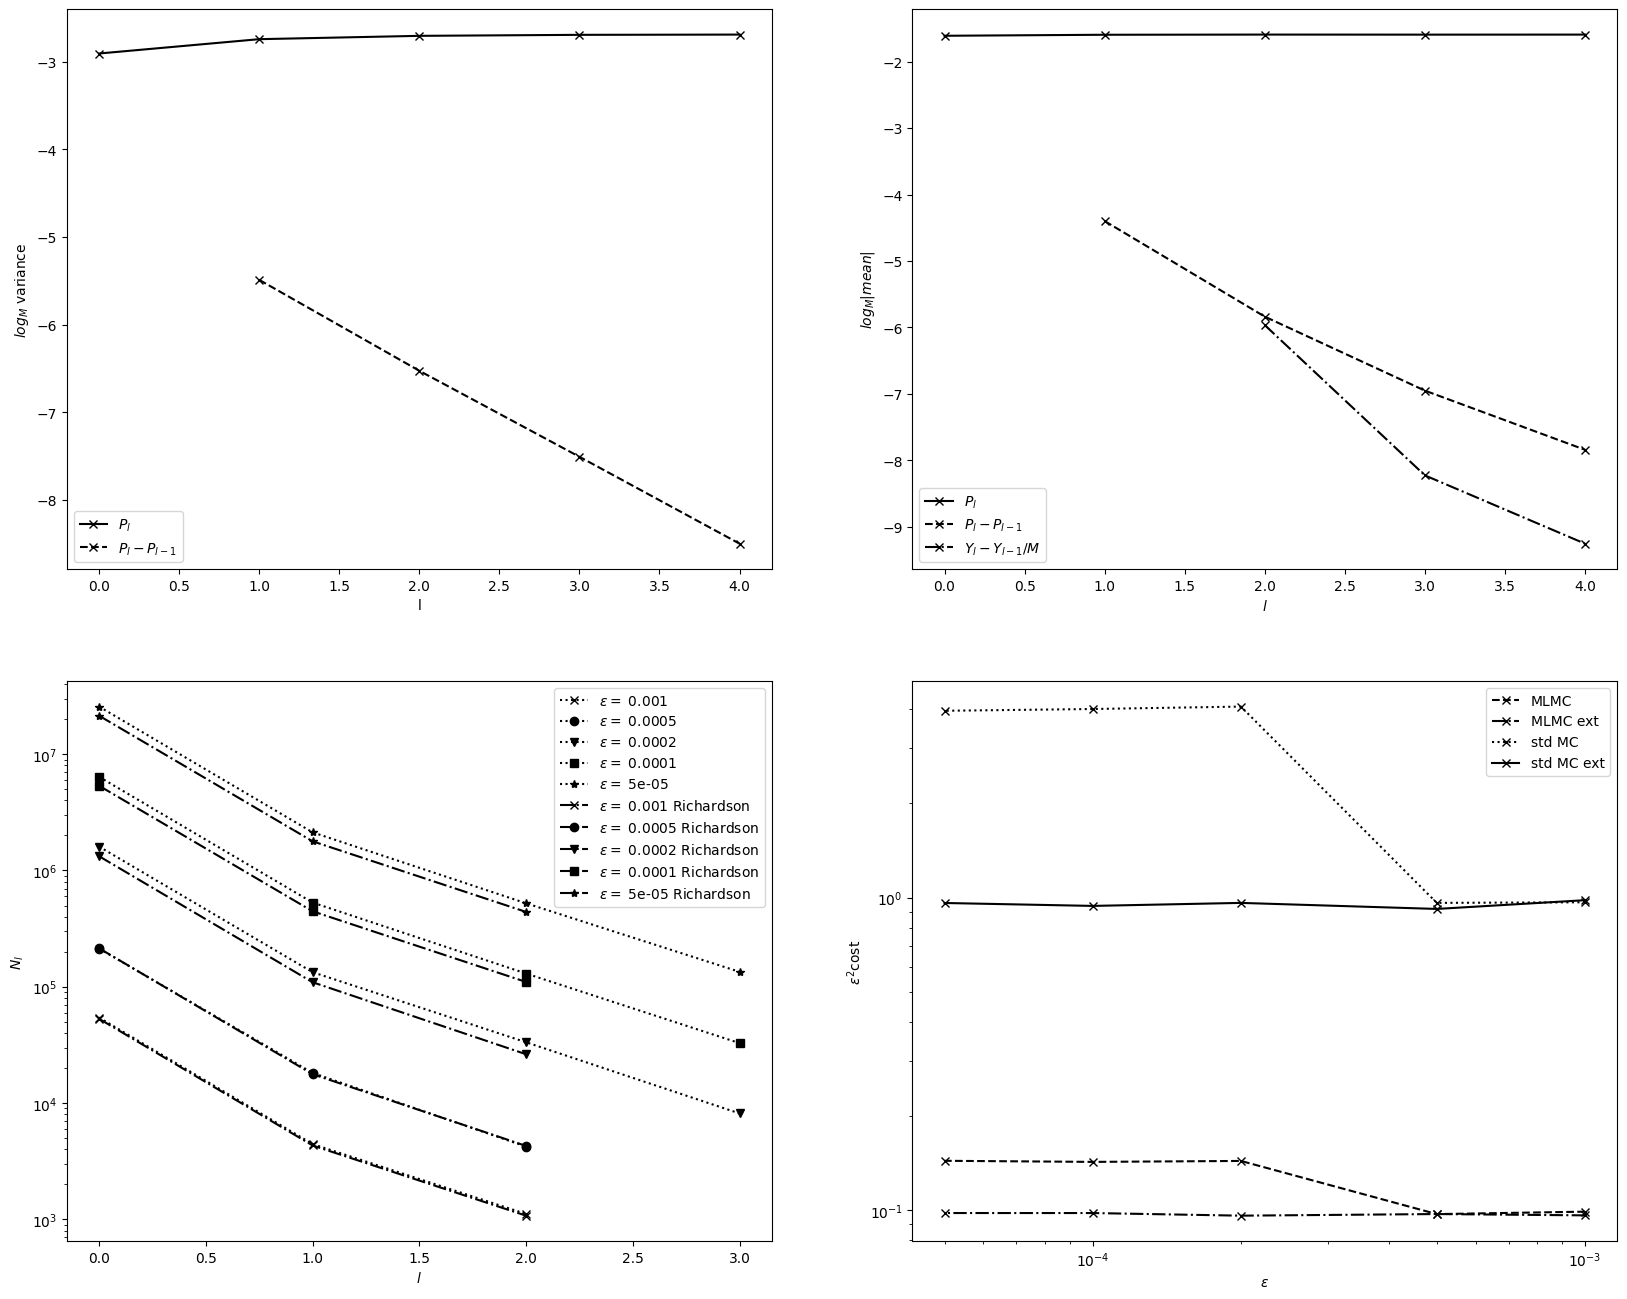

In [24]:
epsilons = np.array([0.001,0.0005,0.0002,0.0001,0.00005])
plots(model = bs,option = european_call,epsilons=epsilons)


In [ ]:
epsilons = np.array([0.001,0.0005,0.0002,0.0001,0.00005])
plots(model=bs, option=asiatic_call,epsilons=epsilons)


Computations for estimation of mean and variance.
epsilon = 0.001
computing mlmc estimator without richardson extrapolation
level : 0
Optimal Nl : [8170.]
level : 1
Optimal Nl : [16520.  4221.]
sampling 6520 new payoffs for level 0
level : 2
Optimal Nl : [23244.  5966.  1227.]
sampling 6724 new payoffs for level 0
convergence test : 
error (should be smaller than target error :  0.001) : 0.0007896184237569758
mean(Y0, ..., YL) = [0.05104468 0.00434507 0.00167503]
var(Y0, ... YL) = [0.0040410315651440406, 0.0010666263683376566, 0.00018026815887180149]
computing mlmc estimator with richardson extrapolation
level : 0
Optimal Nl : [7881.]
level : 1
Optimal Nl : [15975.  4102.]
sampling 5975 new payoffs for level 0
level : 2
Optimal Nl : [22786.  5830.  1207.]
sampling 6811 new payoffs for level 0
convergence test : 
error (should be smaller than target error : 0.001) : 6.136863257545012e-05
mean(Y0, ..., YL) = [0.05072144 0.00390145 0.00162628]
var(Y0, ... YL) = [0.0040010308151103065, 0.0

Computations for estimation of mean and variance.
epsilon = 0.002
computing mlmc estimator without richardson extrapolation
level : 0
Optimal Nl : [8813.]
level : 1
Optimal Nl : [13728.  1914.]
sampling 3728 new payoffs for level 0
level : 2
Optimal Nl : [19736.  2738.   818.]
sampling 6008 new payoffs for level 0
convergence test : 
error (should be smaller than target error :  0.002) : 0.0032008617728145794
level : 3
Optimal Nl : [26171.  3632.  1085.   297.]
sampling 6435 new payoffs for level 0
convergence test : 
error (should be smaller than target error :  0.002) : 0.0008124399173286492
mean(Y0, ..., YL) = [ 0.20728228 -0.02581461 -0.00679005 -0.00172345]
var(Y0, ... YL) = [0.017669122401669568, 0.0013700247392076296, 0.0004884400171511397, 0.00014576312171474907]
computing mlmc estimator with richardson extrapolation
level : 0
Optimal Nl : [8713.]
level : 1
Optimal Nl : [13642.  1930.]
sampling 3642 new payoffs for level 0
level : 2
Optimal Nl : [19449.  2751.   811.]
sampling 

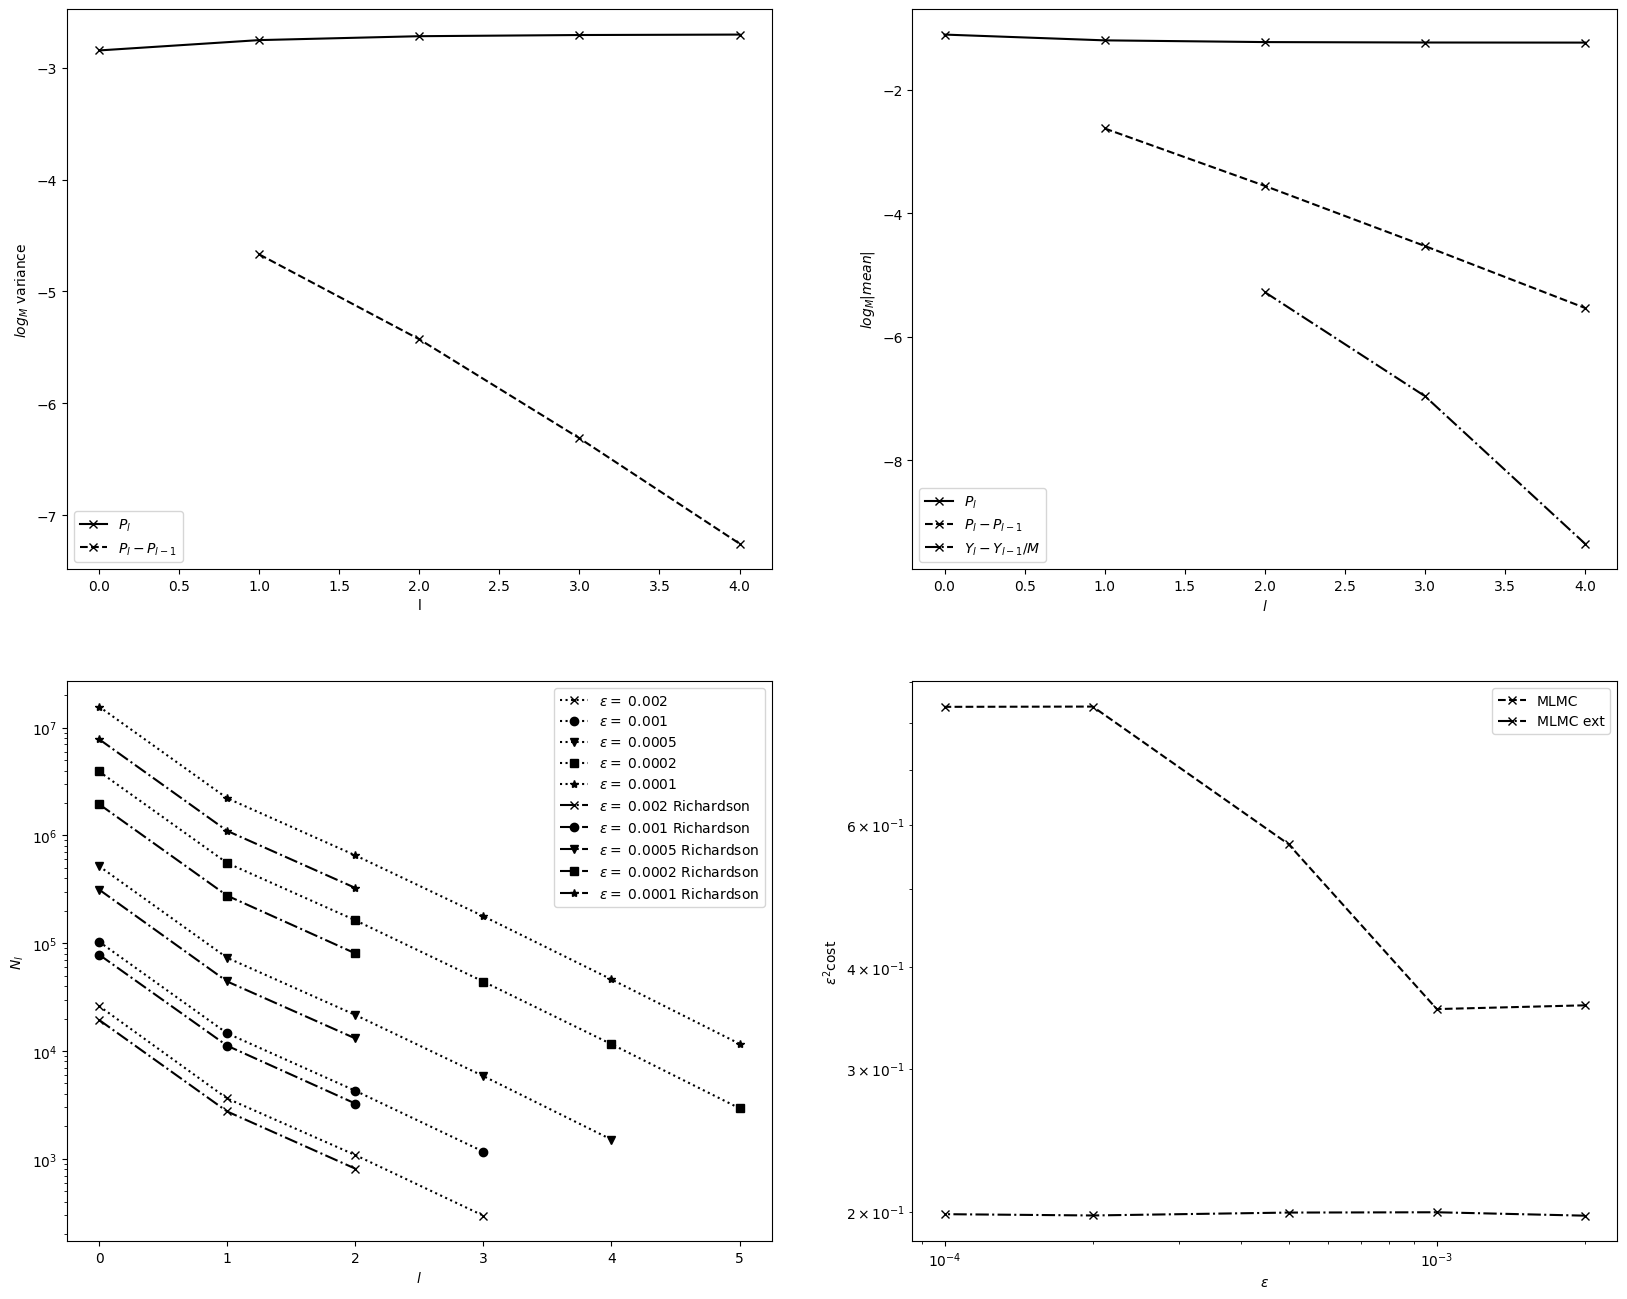

In [82]:
epsilons = np.array([0.002,0.001,0.0005,0.0002,0.0001])
plots(model=bs, option=lookback,epsilons=epsilons)

Computations for estimation of mean and variance.
epsilon = 0.005
computing mlmc estimator without richardson extrapolation
level : 0
Optimal Nl : [17362.]
sampling 7362 new payoffs for level 0
level : 1
Optimal Nl : [29807.  5340.]
sampling 12445 new payoffs for level 0
level : 2
Optimal Nl : [49819.  8920.  3580.]
sampling 20012 new payoffs for level 0
convergence test : 
error (should be smaller than target error :  0.005) : 0.0035648901156017493
mean(Y0, ..., YL) = [ 0.56878246 -0.0302491  -0.00732447]
var(Y0, ... YL) = [0.2175291254688589, 0.02785882210292883, 0.017952616808400237]
computing mlmc estimator with richardson extrapolation
level : 0
Optimal Nl : [17474.]
sampling 7474 new payoffs for level 0
level : 1
Optimal Nl : [29593.  5129.]
sampling 12119 new payoffs for level 0
level : 2
Optimal Nl : [48106.  8359.  3223.]
sampling 18513 new payoffs for level 0
convergence test : 
error (should be smaller than target error : 0.005) : 2.2420692550955454e-06
mean(Y0, ..., YL) = [

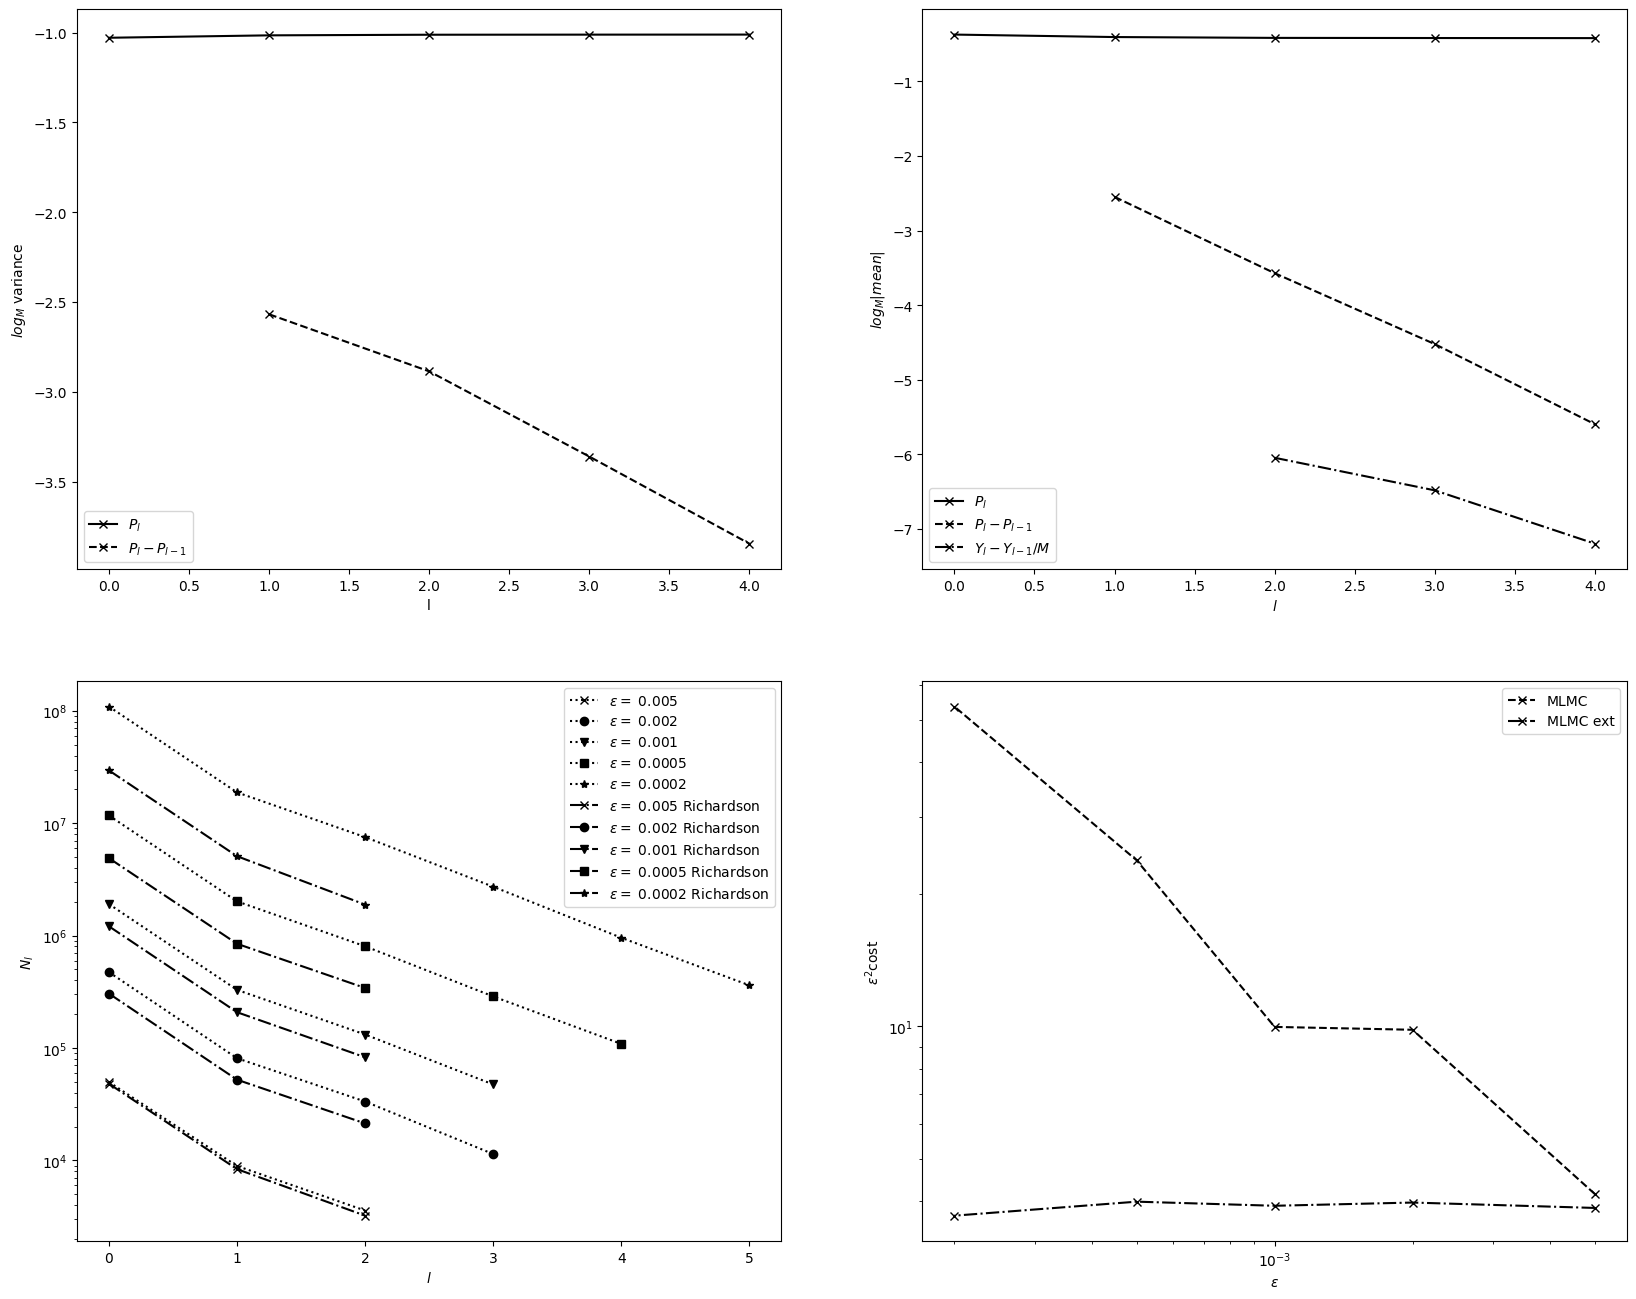

In [83]:
epsilons = np.array([0.005,0.002,0.001,0.0005,0.0002])
plots(model=bs, option=digital, epsilons=epsilons)

Computations for estimation of mean and variance.
epsilon = 0.005
computing mlmc estimator without richardson extrapolation
level : 0
Optimal Nl : [1287.]
level : 1
Optimal Nl : [2293.  449.]
level : 2
Optimal Nl : [4324.  845.  427.]
convergence test : 
error (should be smaller than target error :  0.005) : 0.00039752527154723866
mean(Y0, ..., YL) = [ 0.10199044  0.00337311 -0.00069336]
var(Y0, ... YL) = [0.016084516514796796, 0.0024569387631573976, 0.0025042629370493914]
computing mlmc estimator with richardson extrapolation
level : 0
Optimal Nl : [1270.]
level : 1
Optimal Nl : [2272.  448.]
level : 2
Optimal Nl : [4274.  843.  422.]
convergence test : 
error (should be smaller than target error : 0.005) : 2.7550501901540174e-05
mean(Y0, ..., YL) = [0.10120866 0.00276717 0.00039957]
var(Y0, ... YL) = [0.01587343069262704, 0.0024677331370333106, 0.0024668421741671173]
epsilon = 0.0005
computing mlmc estimator without richardson extrapolation
level : 0
Optimal Nl : [127185.]
sampling 1

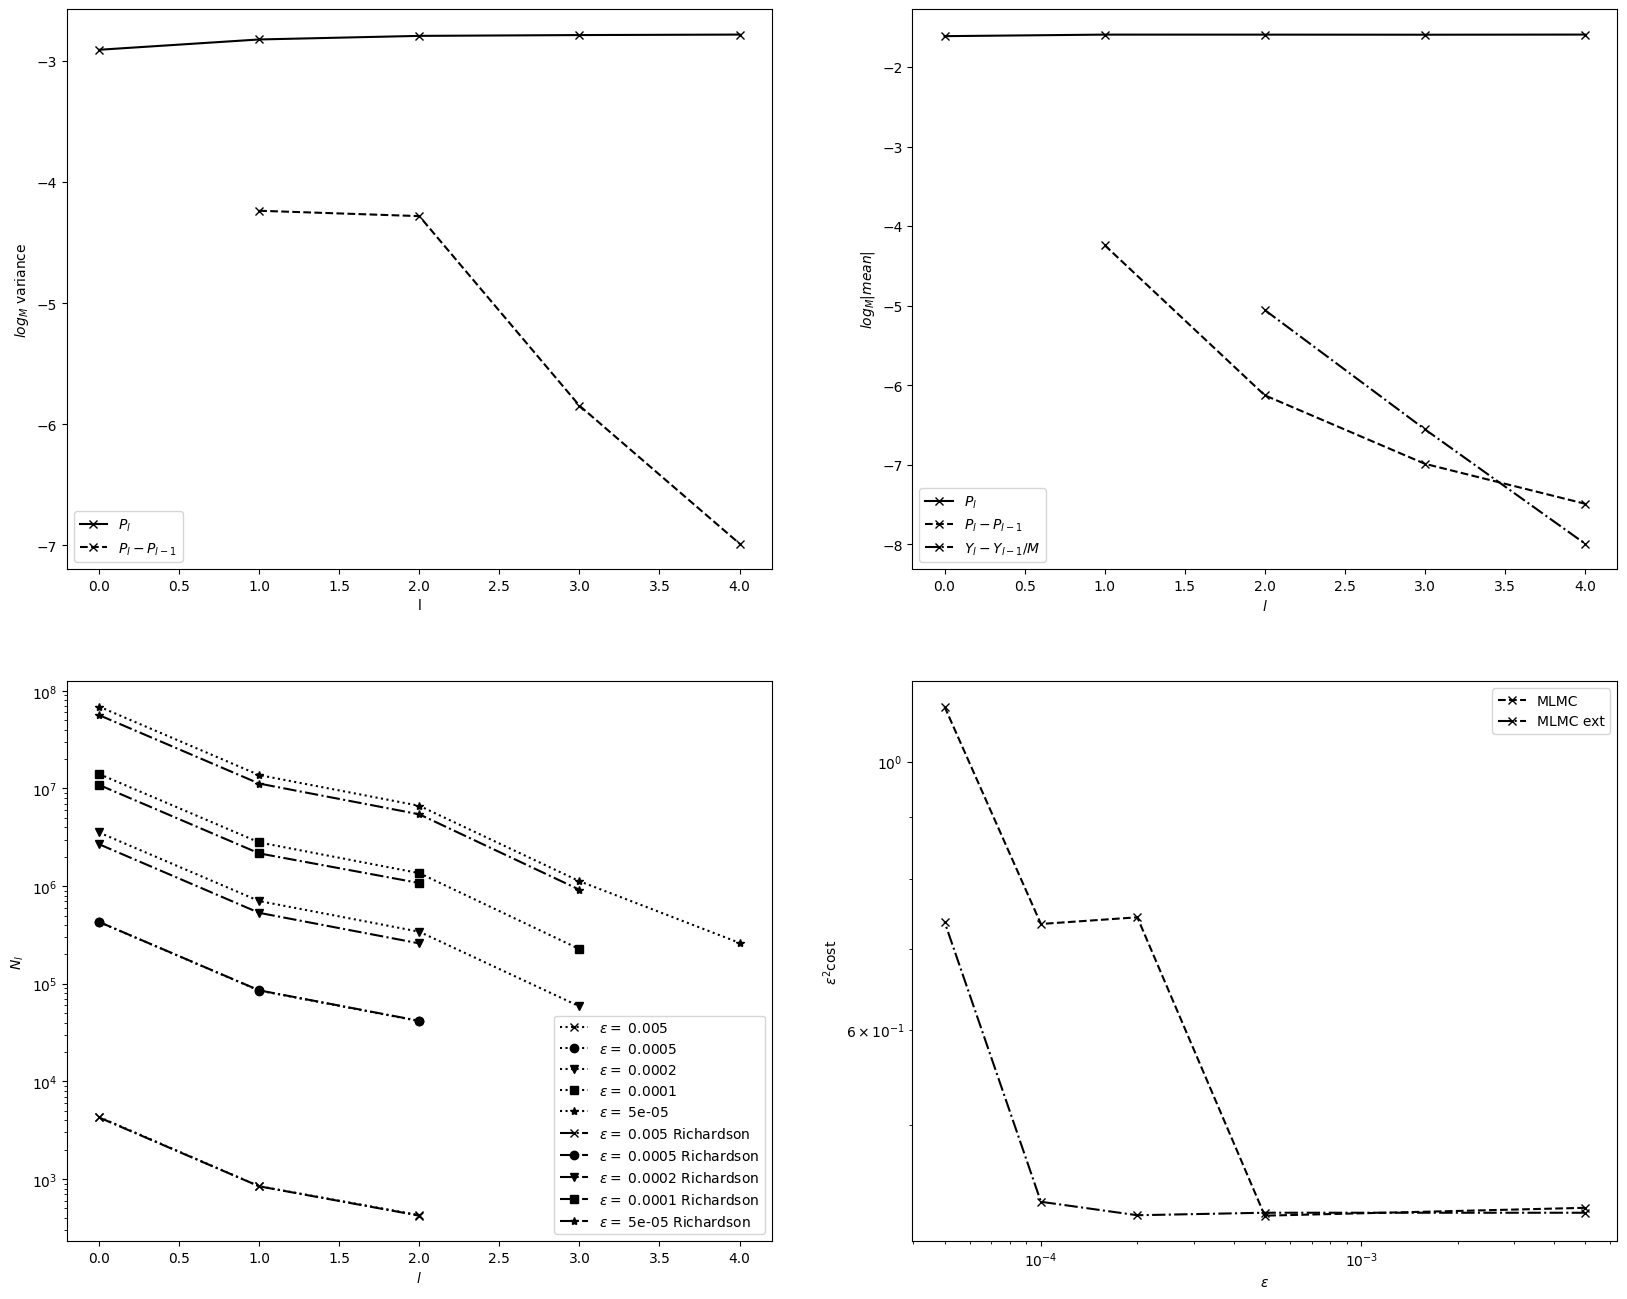

In [84]:
epsilons = np.array([0.005,0.0005,0.0002,0.0001,0.00005])
plots(model=hesto,option=european_call, epsilons=epsilons)